In [1]:
# author Alex J. Yang
import numpy as np
import pandas as pd
import itertools

In [2]:
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
df = pd.read_csv(r'Allpaper.csv.zip')

In [4]:
df.dropna(subset = 'Atyp_Median_Z',inplace = True)

In [5]:
# calculate CI using bootstrap
def calculateCI(data,method,n):
    m=int(len(data)/10) #take 10% data
    ms=[]
    for j in range(n): #number of samples
        if method=='mean':
                ms.append(np.mean(np.random.choice(data,m)))
        if method=='median':
                ms.append(np.median(np.random.choice(data,m)))
    a,b=[np.percentile(ms,2.5),np.percentile(ms,97.5)]
    return a,b

def convert_column_to_percentile(df, column_name):
    ranks = df[column_name].rank()
    percentiles = (ranks - 1) / (len(df) - 1) * 100
    df[column_name + '_percentile'] = percentiles

In [6]:
df['nAtyp_Median_Z'] = -df['Atyp_Median_Z']
convert_column_to_percentile(df, 'nAtyp_Median_Z')

In [7]:
def yearGroup(x):
    if x<1920:
        return '1900-1919'
    elif x<1940:
        return '1920-1939'
    elif x<1960:
        return '1940-1959'
    elif x<1980:
        return '1960-1979'
    else:
        return '1980-1999'
    
def delayGroup(x):
    if x<2:
        return x
    elif x<10:
        return '2-9'
    elif x<20:
        return '10-19'
    elif x<50:
        return '20-49'
    else:
        return '>50'
df['yearGroup'] = df['Year'].apply(yearGroup)
df['delayGroup'] = df['SB_T'].apply(delayGroup)

In [8]:
df1= df[(df['type_Concave'] == 0)&(df['type_Immediacy'] == 0)].copy()
df2 = df[df['type_Concave'] == 1].copy()
df3 = df[df['type_Immediacy'] == 1].copy()

In [9]:
convert_column_to_percentile(df1, 'SB_B')
def BpGroup(x):
    if x<5:
        return 5
    elif x<50:
        return 50
    elif x<95:
        return 95
    else:
        return 100
df1['SB_B_p'] = df1['SB_B_percentile'].apply(BpGroup)

In [10]:
df.columns

Index(['PaperID', 'Year', 'JournalID', 'SB_B', 'SB_T', 'type_Immediacy',
       'type_Concave', 'Citation_Count', 'C10', 'Reference_Count', 'C5',
       'Team_Size', 'Institution_Count', 'Disruption', 'Atyp_10pct_Z',
       'Atyp_Median_Z', 'Patent_Count', 'Newsfeed_Count', 'Tweet_Count',
       'FieldID', 'Fieldname', 'Hit_1pct', 'Hit_5pct', 'Hit_10pct', 'C_f',
       'nAtyp_Median_Z', 'nAtyp_Median_Z_percentile', 'yearGroup',
       'delayGroup'],
      dtype='object')

In [11]:
dflst = [df , df1 , df2 , df3]

# Novelty

In [19]:
x = range(6)
typelst = [0,1,'2-9', '10-19', '20-49','>50']
colum = 'nAtyp_Median_Z_percentile'
y = np.array([df[df['delayGroup']==x][colum].mean() for x in typelst])
CI = np.array([calculateCI( df[df['delayGroup']==x][colum].values , 'mean' , 100)[1] for x in typelst])
CI = CI-y

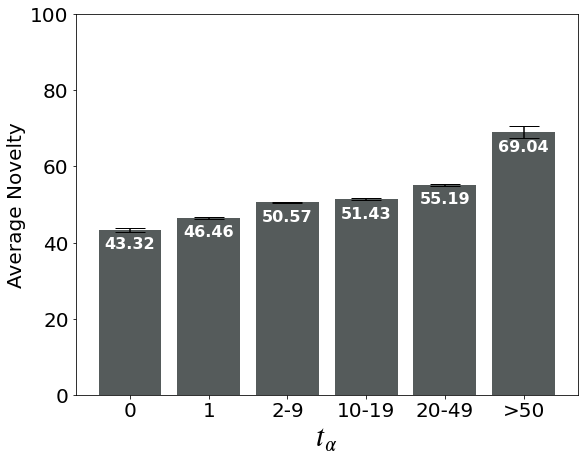

In [21]:
f, ax = plt.subplots(figsize=(9, 7))
plt.bar(x , y , yerr = CI , capsize = 15 ,color='#424949', alpha = .9)
plt.yticks(fontsize=20,)
plt.xticks(x,typelst,fontsize=20,)
plt.ylim(0,100)
plt.ylabel('Average Novelty',fontsize = 20)
plt.xlabel(r'$𝑡_𝛼$',fontsize = 30)
for _ in range(len(y)):
    plt.text(x[_], y[_]-5 , str(y[_].round(2)),fontsize = 16,c = 'white', ha='center', fontweight='bold')

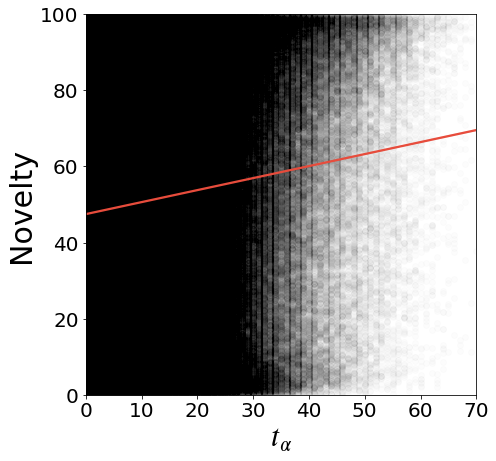

In [26]:
f, ax = plt.subplots(figsize=(7, 7))
plt.scatter(df['SB_T'], df['nAtyp_Median_Z_percentile'], c = 'black',s=5, alpha = 0.01)
sns.regplot(data = df, y='nAtyp_Median_Z_percentile' , x='SB_T',x_ci = 95 , n_boot = 100 ,seed = 0 , color = '#E74C3C',scatter = False)
plt.ylim(0,100)
plt.xlim(0,70)
plt.yticks(fontsize=20,)
plt.xticks(fontsize=20,)
plt.ylabel('Novelty',fontsize = 30)
plt.xlabel(r'$𝑡_𝛼$',fontsize = 30)
plt.show()

In [28]:
x = range(6)
typelst = ['convex','immediacy','0-5','5-50','50-95','95-100']
CClst = [5,50,95,100]
colum = 'nAtyp_Median_Z_percentile'
y1 = np.array([df1[df1['SB_B_p']==x][colum].mean() for x in CClst])
CI1 = np.array([calculateCI( df1[df1['SB_B_p']==x][colum].values , 'mean' , 100)[1] for x in CClst])
CI1 = CI1-y1

y2 =  np.array(df2[colum].mean())
y3 =  np.array(df3[colum].mean())
CI2 = np.array(calculateCI( df2[colum].values , 'mean' , 100)[1])
CI3 = np.array(calculateCI( df3[colum].values , 'mean' , 100)[1])
CI2 = CI2-y2
CI3 = CI3-y3

y =  np.append(np.array([y2,y3]),y1)
CI = np.append(np.array([CI2,CI3]),CI1)

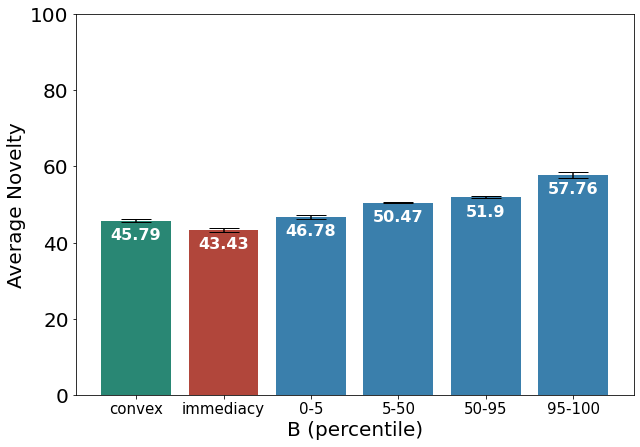

In [29]:
f, ax = plt.subplots(figsize=(10, 7))
plt.bar(x , y , yerr = CI , capsize = 15 ,color=['#117A65','#A93226']+['#2471A3']*4, alpha = .9)
plt.yticks(fontsize=20,)
plt.xticks(x,typelst,fontsize=15,)
plt.ylim(0,100)
plt.ylabel('Average Novelty',fontsize = 20)
plt.xlabel('B (percentile)',fontsize = 20)
for _ in range(len(y)):
    plt.text(x[_], y[_]-5 , str(y[_].round(2)),fontsize = 16,c = 'white', ha='center', fontweight='bold')

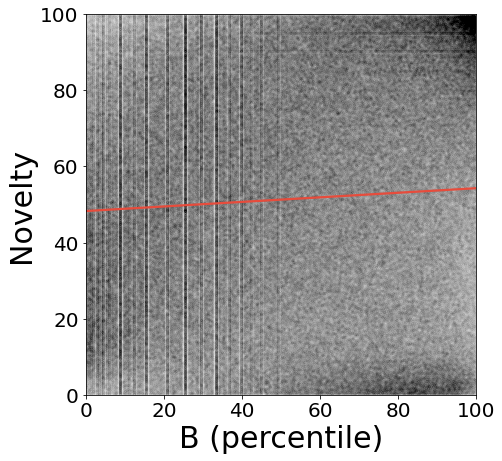

In [27]:
f, ax = plt.subplots(figsize=(7, 7))
plt.scatter(df1['SB_B_percentile'], df1['nAtyp_Median_Z_percentile'], c = 'black',s=5, alpha = 0.005)
sns.regplot(data = df1, y='nAtyp_Median_Z_percentile' , x='SB_B_percentile',x_ci = 95 , n_boot = 100 ,seed = 0 , color = '#E74C3C',scatter = False)
plt.ylim(0,100)
plt.xlim(0,100)
plt.yticks(fontsize=20,)
plt.xticks(fontsize=20,)
plt.ylabel('Novelty',fontsize = 30)
plt.xlabel('B (percentile)',fontsize = 30)
plt.show()